In [2]:
cd /home/blansdel/projects/schwarz/decoder

/home/blansdel/projects/schwarz/decoder


In [28]:
import matplotlib.pyplot as plt 
import numpy as np
import pandas as pd
import pickle 

from collections import defaultdict
from scipy.stats import ranksums
from scipy.stats import chi2_contingency

In [4]:
TEST_IDX = 1
TRAIN_IDX = 2 
VAL_IDX = 3

In [5]:
#Load the pickle files
with open('data/output/day9results.pkl', 'rb') as f:
    day9results = pickle.load(f)

with open('data/output/day7results.pkl', 'rb') as f:
    day7results = pickle.load(f)

with open('data/output/day6results.pkl', 'rb') as f:
    day6results = pickle.load(f)

In [6]:
certain_thresh = 0.999
certainnot_thresh = 0.001

In [81]:
def plot_decoder(res, suptitle):
    fig, axes = plt.subplots(3, 3, figsize = (16,16), sharex = True, sharey = True)
    certain_counts = {}

    for idx, k in enumerate(res[list(res.keys())[0]][1].keys()):
        y_test, y_preds_test, y_preds_test_proba = res[list(res.keys())[0]][1][k]
        y_test = y_test.reshape((12,-1))
        y_preds_test = y_preds_test.reshape((12,-1))
        y_preds_test_proba = y_preds_test_proba[:,0].reshape((12,-1))

        i,j = divmod(idx, 3)

        axes[i,j].imshow(y_test, aspect = 'auto', interpolation = 'none', cmap = 'Greys', vmin = 0, vmax = 3)
        axes[i,j].axvline(x = 200, color = 'black')
        axes[i,j].axvline(x = 280, color = 'black')
        xx = range(len(y_preds_test_proba[0]))
        for t in range(12):
            axes[i,j].plot(xx, 0.8*y_preds_test_proba[t]+t-0.45, color = 'green')
        y_preds_test_proba_certain = (y_preds_test_proba > certain_thresh).astype(int)
        y_preds_test_proba_certainnot = (y_preds_test_proba < certainnot_thresh).astype(int)
        certain_counts[k] = np.sum(np.diff(y_preds_test_proba_certain, axis = 1) == 1, axis = 1) + \
                            np.sum(np.diff(y_preds_test_proba_certainnot, axis = 1) == 1, axis = 1)
        title = f"{k[0]} {k[1]}"
        axes[i,j].set_title(title)
    fig.suptitle(suptitle)
    return certain_counts


def present_results(results_d7, results_d9, title = None):
    results = pd.concat([results_d7, results_d9])
    results['Session'] = results['Session_trial'].str.split('_').str[0]
    results['Pred_reward_trial'] = (results['Prop_pred_reward_trial'] > 0.5).astype(float)

    prediction_counts = results.groupby(['treatment', 'Session'])['Pred_reward_trial', 'Reward'].sum().reset_index()
    prediction_counts['Previously_rewarded'] = 36-prediction_counts['Reward']

    fig, axes = plt.subplots(2,2, figsize = (10, 10), sharey = True)
    if title:
        fig.suptitle(f'Time points: {title}')
    for idx, session in enumerate(['7', '9']):
        axes[0,idx].bar(x = [1,2,3], 
                    height = prediction_counts[prediction_counts.Session == session].Pred_reward_trial,
                    tick_label = prediction_counts[prediction_counts.Session == session].treatment)
        axes[0,idx].set_xlabel('treatment')
        axes[0,idx].set_ylabel('Predicted reward trials (/36)')
        axes[0,idx].set_title(f'Day {session}')

    for idx, session in enumerate(['7', '9']):
        axes[1,idx].bar(x = [1,2,3], 
                    height = prediction_counts[prediction_counts.Session == session].Previously_rewarded,
                    tick_label = prediction_counts[prediction_counts.Session == session].treatment)
        axes[1,idx].set_xlabel('treatment')
        axes[1,idx].set_ylabel('Previously rewarded trials (/36)')

    return prediction_counts

def compute_stats(prediction_counts, title = ''):
    pairs = [('Clonidine', 'Control'),('Clonidine', 'Idazoxan'),('Control', 'Idazoxan')]
    days = ['7', '9']
    test_results = np.zeros((len(pairs), len(days)))
    for i,pair in enumerate(pairs):
        for j,day in enumerate(days):
            row1_val = prediction_counts[(prediction_counts.Session == day) & (prediction_counts.treatment == pair[0])]['Pred_reward_trial'].values[0]
            row2_val = prediction_counts[(prediction_counts.Session == day) & (prediction_counts.treatment == pair[1])]['Pred_reward_trial'].values[0]
            if (row1_val == row2_val == 36) or (row1_val == row2_val == 36):
                pval = -1
            else:
                c_table = [[row1_val, 36-row1_val], [row2_val, 36-row2_val]]
                pval = chi2_contingency(c_table)[1]
            test_results[i,j] = pval
    test_results_pred_trials = pd.DataFrame(test_results, index = pairs, columns = days)

    test_results = np.zeros((len(pairs), len(days)))
    for i,pair in enumerate(pairs):
        for j,day in enumerate(days):
            row1_val = prediction_counts[(prediction_counts.Session == day) & (prediction_counts.treatment == pair[0])]['Previously_rewarded'].values[0]
            row2_val = prediction_counts[(prediction_counts.Session == day) & (prediction_counts.treatment == pair[1])]['Previously_rewarded'].values[0]
            c_table = [[row1_val, 36-row1_val], [row2_val, 36-row2_val]]
            pval = chi2_contingency(c_table)[1]
            test_results[i,j] = pval
    test_results_reward_trials = pd.DataFrame(test_results, index = pairs, columns = days)

    print(title)
    print('Test reward prediction comparisons')
    print(test_results_pred_trials)
    print(title)
    print('Test rewarded trials comparisons')
    print(test_results_reward_trials)
    return test_results_pred_trials, test_results_reward_trials

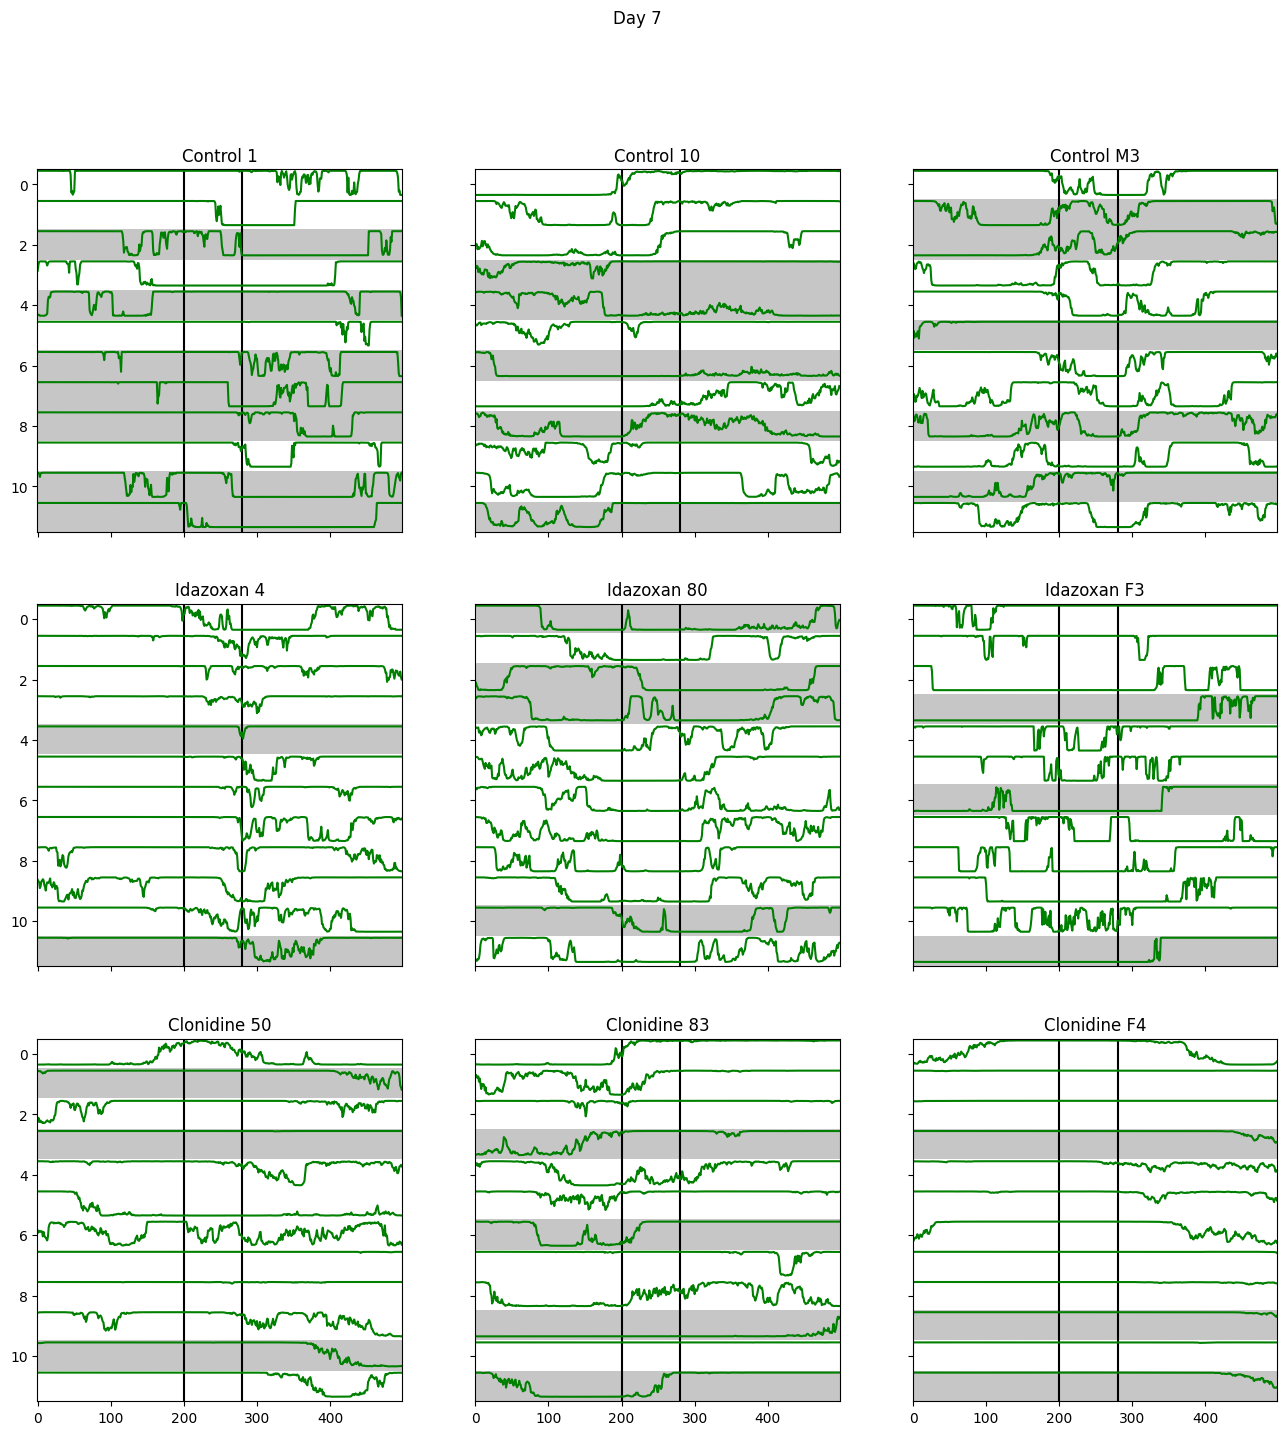

In [82]:
certain_counts_d7 = plot_decoder(day7results, 'Day 7')

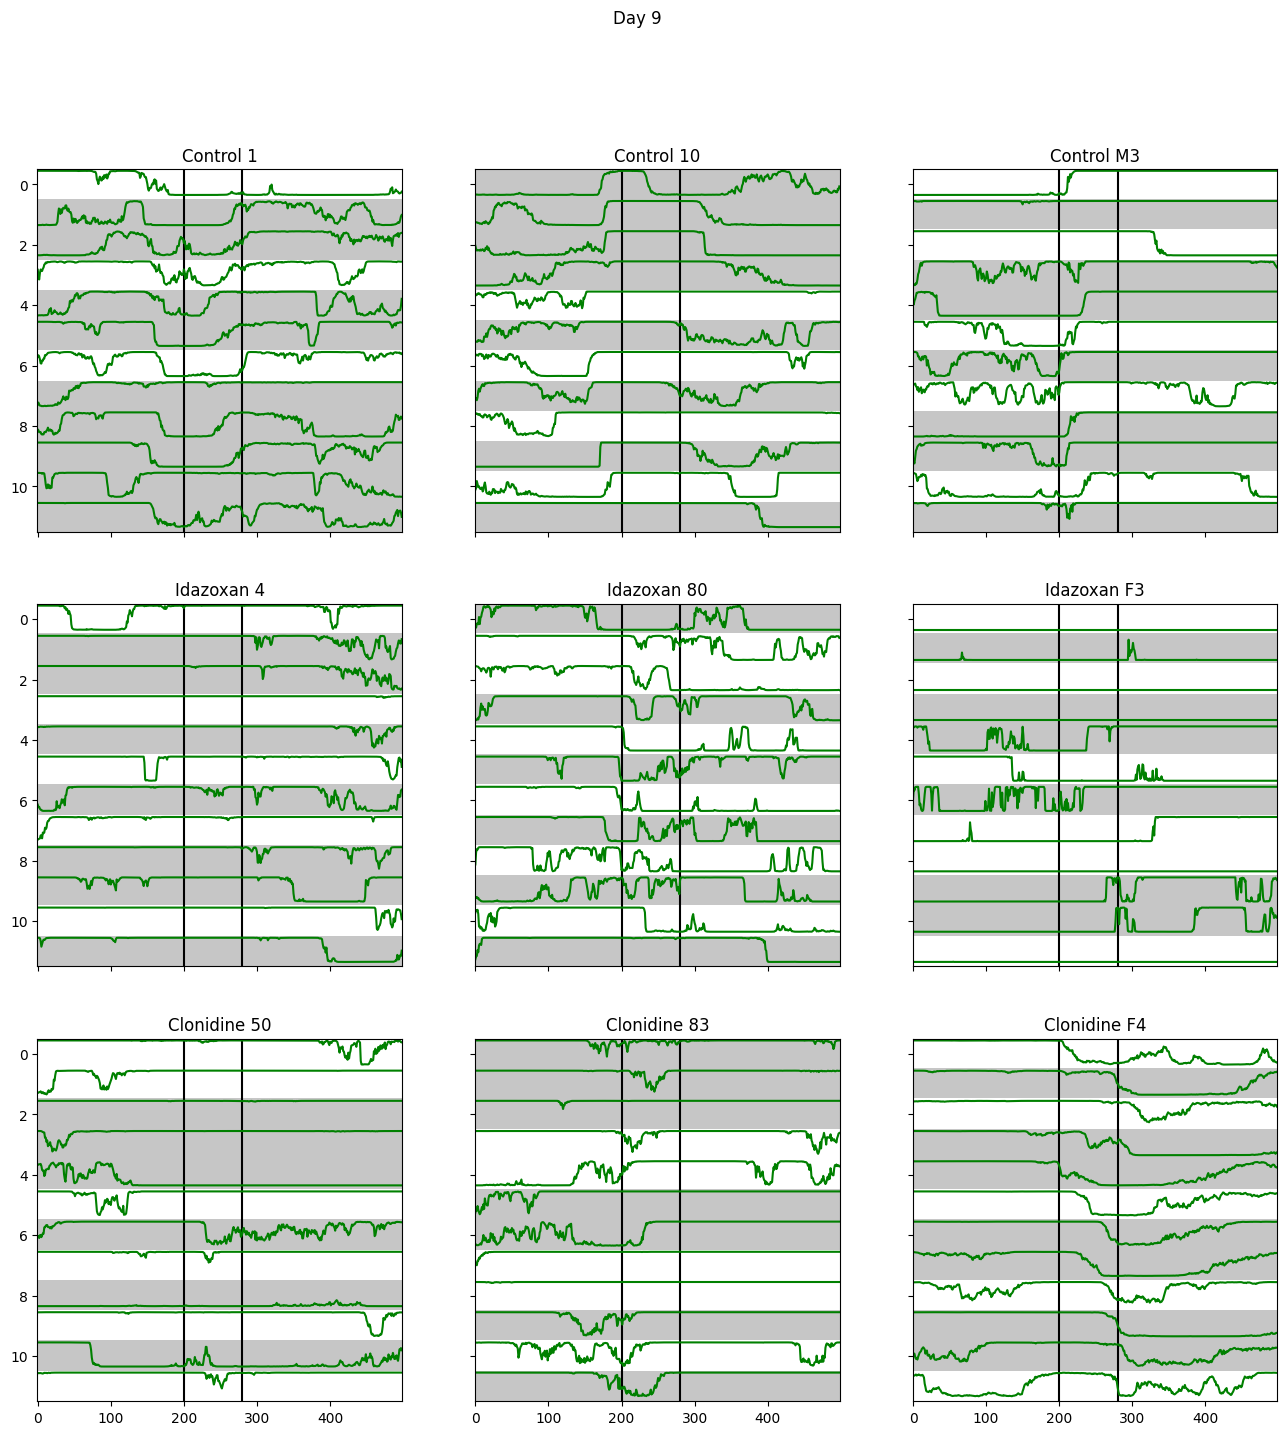

In [83]:
certain_counts_d9 = plot_decoder(day9results, 'Day 9')

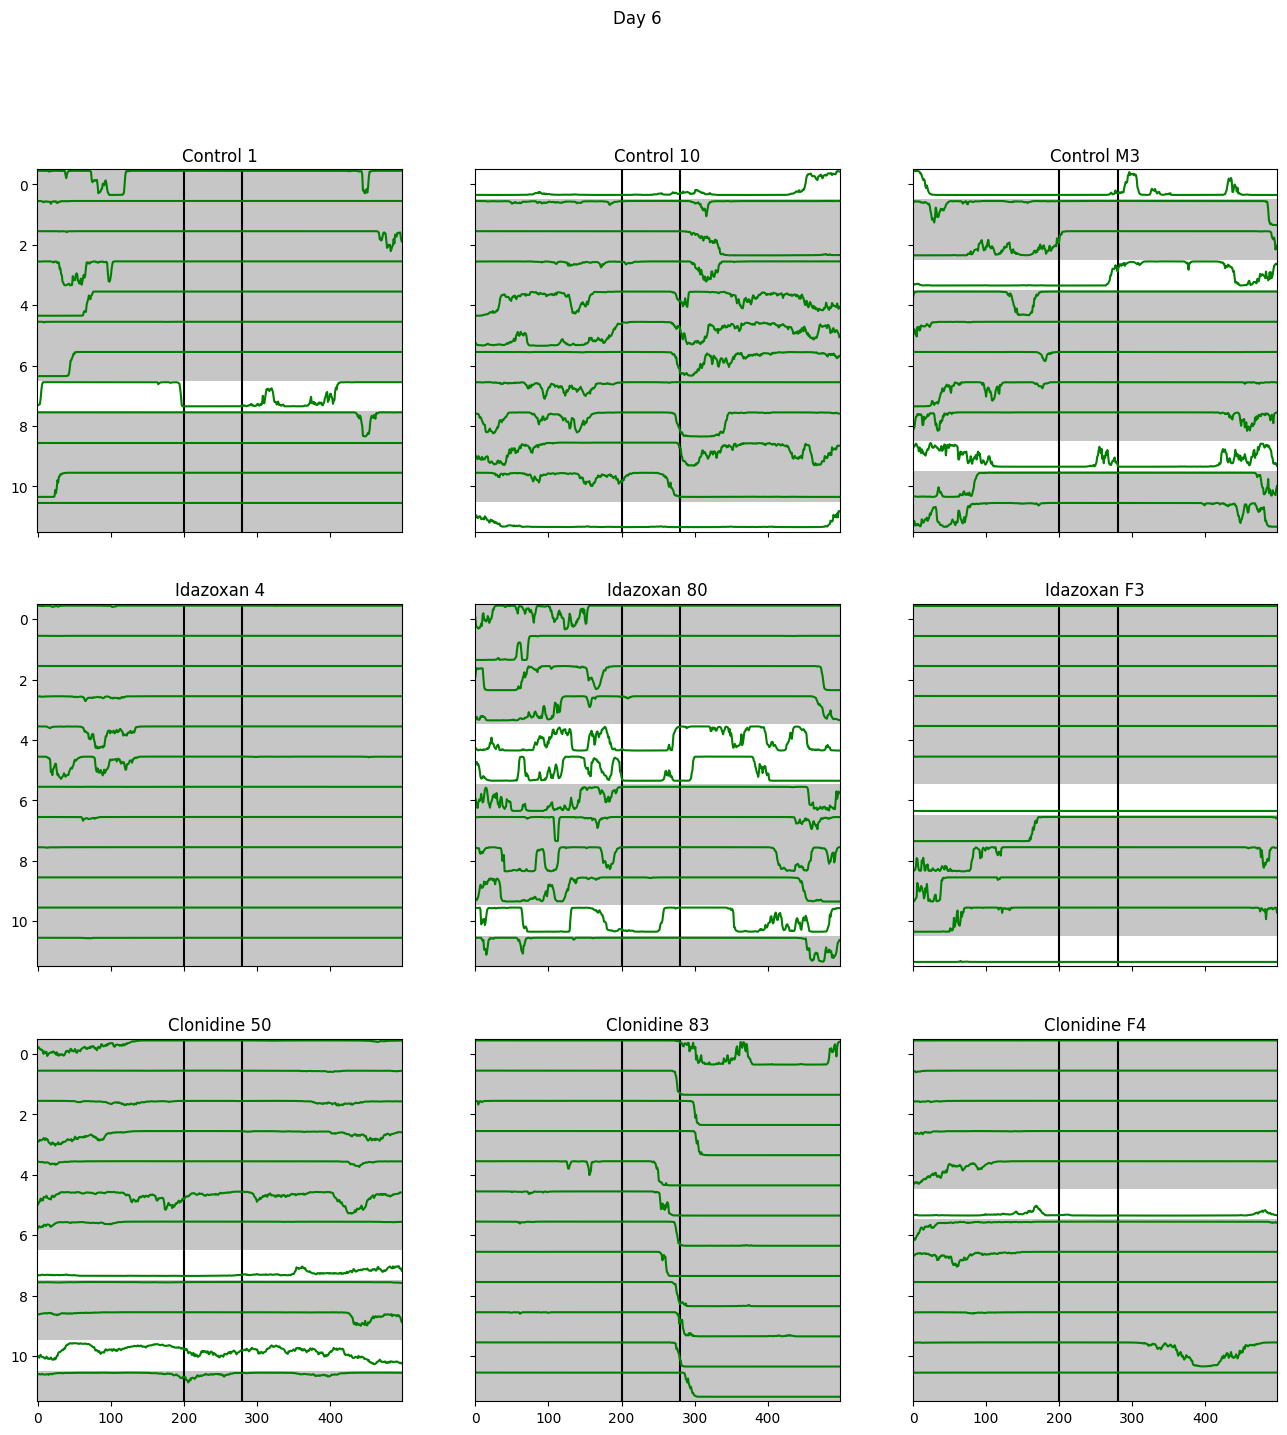

In [84]:
certain_counts_d6 = plot_decoder(day6results, 'Day 6')

## Count number of switches between certain predictions

Day 7

In [85]:
switches_by_groups = defaultdict(list)
for k in certain_counts_d7:
    switches_by_groups[k[0]] += list(certain_counts_d7[k])

print("Control v idazoxan", ranksums(switches_by_groups['Control'], switches_by_groups['Idazoxan']))
print("Control v clonidine", ranksums(switches_by_groups['Control'], switches_by_groups['Clonidine']))
print("Clonidine v idazoxan", ranksums(switches_by_groups['Clonidine'], switches_by_groups['Idazoxan']))

Control v idazoxan RanksumsResult(statistic=-1.9314826732585306, pvalue=0.05342339001325939)
Control v clonidine RanksumsResult(statistic=0.8840897367393274, pvalue=0.37664777306231634)
Clonidine v idazoxan RanksumsResult(statistic=-2.376343114038192, pvalue=0.017485195203169417)


In [86]:
for group in switches_by_groups:
    print(group, np.median(switches_by_groups[group]))

Control 9.5
Idazoxan 12.0
Clonidine 8.5


Day 9

In [87]:
switches_by_groups = defaultdict(list)
for k in certain_counts_d9:
    switches_by_groups[k[0]] += list(certain_counts_d9[k])

print("Control v idazoxan", ranksums(switches_by_groups['Control'], switches_by_groups['Idazoxan']))
print("Control v clonidine", ranksums(switches_by_groups['Control'], switches_by_groups['Clonidine']))
print("Clonidine v idazoxan", ranksums(switches_by_groups['Clonidine'], switches_by_groups['Idazoxan']))

Control v idazoxan RanksumsResult(statistic=-3.6377195537172327, pvalue=0.0002750626916646098)
Control v clonidine RanksumsResult(statistic=-0.06757373783994859, pvalue=0.9461249617684676)
Clonidine v idazoxan RanksumsResult(statistic=-3.192859112937571, pvalue=0.0014087165950319722)


In [88]:
for group in switches_by_groups:
    print(group, np.median(switches_by_groups[group]))

Control 6.0
Idazoxan 11.0
Clonidine 6.0


Day 6

In [89]:
switches_by_groups = defaultdict(list)
for k in certain_counts_d6:
    switches_by_groups[k[0]] += list(certain_counts_d6[k])
print("Control v idazoxan", ranksums(switches_by_groups['Control'], switches_by_groups['Idazoxan']))
print("Control v clonidine", ranksums(switches_by_groups['Control'], switches_by_groups['Clonidine']))
print("Clonidine v idazoxan", ranksums(switches_by_groups['Clonidine'], switches_by_groups['Idazoxan']))

Control v idazoxan RanksumsResult(statistic=0.05631144819995716, pvalue=0.9550936989624449)
Control v clonidine RanksumsResult(statistic=1.3176878878789977, pvalue=0.1876081508098646)
Clonidine v idazoxan RanksumsResult(statistic=-1.0980732398991646, pvalue=0.27217250939746407)


In [90]:
for group in switches_by_groups:
    print(group, np.median(switches_by_groups[group]))

Control 5.5
Idazoxan 6.0
Clonidine 3.0


### Summarize predictions on reversal days

In [ ]:
with open('data/output/day9results_shorttest.pkl', 'rb') as f:
    day9results = pickle.load(f)

with open('data/output/day7results_shorttest.pkl', 'rb') as f:
    day7results = pickle.load(f)

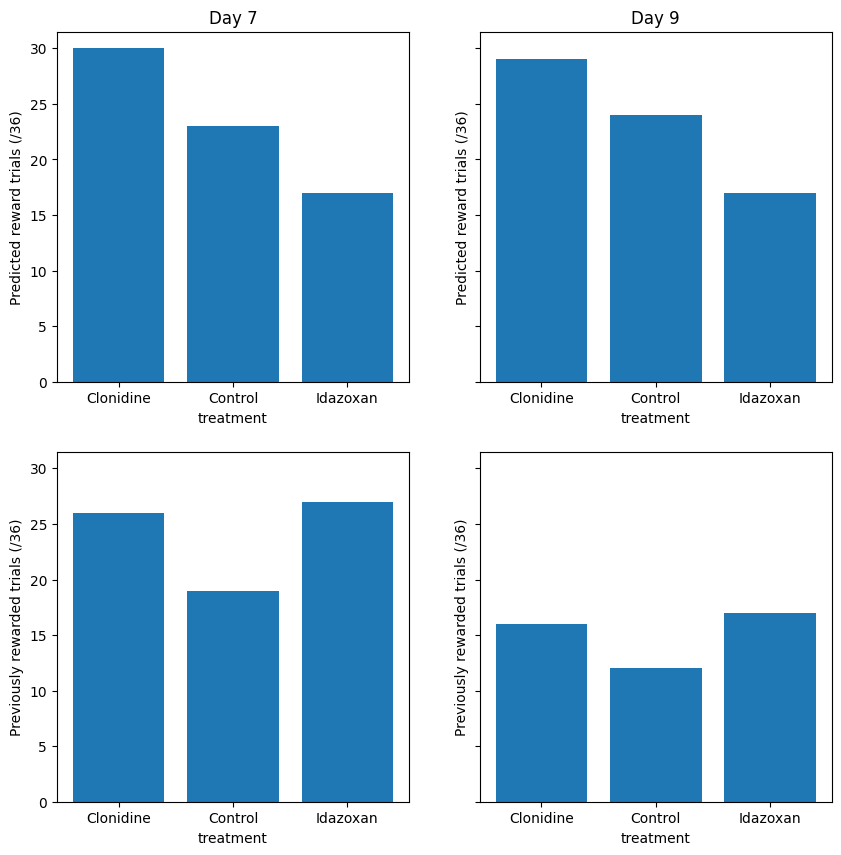

In [23]:
for rd7, rd9 in zip(day7results.keys(), day9results.keys()):
    if rd7[1][0] != 201: continue
    prediction_counts = present_results(day7results[rd7][0], day9results[rd9], title = rd7[1])
    test_results_pred_trials, test_results_reward_trials = compute_stats(prediction_counts, title = rd7[1])

In [27]:
prediction_counts

,treatment,Session,Pred_reward_trial,Reward,Previously_rewarded
0,Clonidine,7,30.0,10.0,26.0
1,Clonidine,9,29.0,20.0,16.0
2,Control,7,23.0,17.0,19.0
3,Control,9,24.0,24.0,12.0
4,Idazoxan,7,17.0,9.0,27.0
5,Idazoxan,9,17.0,19.0,17.0
